In [67]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import talib
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll

sys.path.insert(0, 'libraries')
from cream import TimeSeriesFeatures, AppliedStrategy
from model_builder import OptimalModel, ModelBuilder

In [68]:
df_mset = pd.read_csv('../cotton/data/df_on_call_modelset.csv')
df_mset['date'] = pd.to_datetime(df_mset['date'])

In [86]:
misc_vars = ['date']
outcome_vars = ['value_delta_mean_30_forward',
 'value_delta_max_30_forward',
 'pct_delta_mean_30_forward',
 'pct_delta_max_30_forward',
 'mean_rise_30_forward',
 'max_rise_30_forward']
vars_with_missings = ['unfixed_sale_calls_month_6_away', 'unfixed_sale_calls_month_7_away', 'unfixed_sale_calls_month_8_away', 'unfixed_purchase_calls_month_6_away', 'unfixed_purchase_calls_month_7_away', 'unfixed_purchase_calls_month_8_away']
feat_vars = [x for x in df_mset.columns if x not in misc_vars + outcome_vars + vars_with_missings]
outcome_var = 'value_delta_mean_30_forward'

In [87]:
df_mset = df_mset[df_mset[outcome_var].notnull()]

In [88]:
period_var = 'date'
cut_point = (df_mset[period_var].max() - df_mset[period_var].min())*0.8 + df_mset[period_var].min()
df_train = df_mset[df_mset[period_var] < cut_point].sort_values(period_var).copy()
df_test = df_mset[df_mset[period_var] >= cut_point].sort_values(period_var).copy()

In [89]:
df_train[feat_vars].isnull().sum()

report_week                                 0
report_month                                0
unfixed_sale_calls_month_1_away             0
unfixed_sale_calls_month_2_away             0
unfixed_sale_calls_month_3_away             0
unfixed_sale_calls_month_4_away             0
unfixed_sale_calls_month_5_away             0
unfixed_sale_report_week_total_calls        0
unfixed_purchase_calls_month_1_away         0
unfixed_purchase_calls_month_2_away         0
unfixed_purchase_calls_month_3_away         0
unfixed_purchase_calls_month_4_away         0
unfixed_purchase_calls_month_5_away         0
unfixed_purchase_report_week_total_calls    0
sin_report_week                             0
cos_report_week                             0
dtype: int64

In [112]:
space_lgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 5, 150, 5)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 2, 16, 1)),
    # 'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 2, 150, 1)),
    'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [3, 5, 10, 20, 30, 40, 50, 60, 70, 80])),
    'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
    'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
    # 'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01),
    # 'outcome_var': hp.choice('outcome_var', vars)
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    #,'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

space_logistic_regularised = {
  'penalty':hp.choice('penalty', ['l1']),
  'solver':hp.choice('solver', ['saga', 'liblinear']),  
  'C': hp.quniform('C', 0.01, 1, 0.01),
  'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01)
}

space_lasso = {
  'alpha': hp.uniform('alpha', 0, 1),
  'max_iter': hp.choice('max_iter', [1000000]) 
}


opt = OptimalModel(df_train=df_train[df_train.report_month == 2],
                   df_test=df_test[df_test.report_month == 2],
                   cols=['report_week', 'unfixed_purchase_calls_month_2_away', 'unfixed_sale_calls_month_2_away'], 
                   outcome_var='value_delta_mean_30_forward',
                   model_type='lasso', 
                   evals=300, 
                   opt_lib='hp', 
                   search_space=space_lasso, 
                   how_to_tune='cross_val_standardised', 
                   eval_metric='neg_mean_squared_error',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='regression', 
                   k=5,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
  0%|                                   | 0/300 [00:00<?, ?trial/s, best loss=?]

job exception: The number of folds must be of Integral type. n of type <class 'str'> was passed.



  0%|                                   | 0/300 [00:00<?, ?trial/s, best loss=?]


ValueError: The number of folds must be of Integral type. n of type <class 'str'> was passed.

In [113]:
importance

,feature,coef,prop
0,unfixed_purchase_calls_month_2_away,-0.000683,0.847162
1,unfixed_sale_calls_month_2_away,0.000123,0.152838
2,report_week,0.000000,0.000000


<Axes: xlabel='unfixed_sale_calls_month_2_away', ylabel='pct_delta_mean_30_forward'>

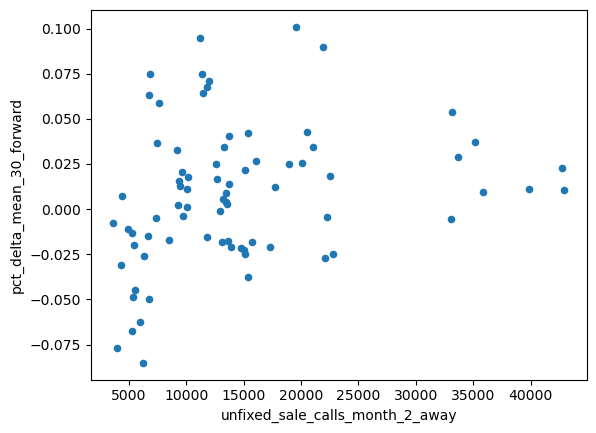

In [109]:
df_train[df_train.report_month == 2].plot(x='unfixed_sale_calls_month_2_away', y='pct_delta_mean_30_forward', kind='scatter')

<Axes: xlabel='unfixed_purchase_calls_month_2_away', ylabel='pct_delta_mean_30_forward'>

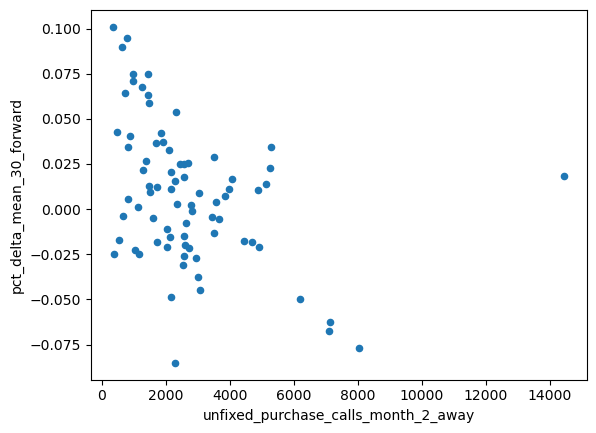

In [106]:
df_train[df_train.report_month == 2].plot(x='unfixed_purchase_calls_month_2_away', y='pct_delta_mean_30_forward', kind='scatter')

In [107]:
importance

,feature,coef,prop
0,unfixed_purchase_calls_month_4_away,-0.002211,0.340174
1,unfixed_sale_calls_month_3_away,0.000815,0.125380
2,unfixed_purchase_calls_month_3_away,-0.000618,0.095124
3,unfixed_sale_calls_month_5_away,0.000603,0.092731
4,unfixed_purchase_calls_month_1_away,-0.000507,0.078091
5,unfixed_sale_calls_month_1_away,0.000386,0.059405
6,unfixed_purchase_calls_month_2_away,-0.000347,0.053458
7,unfixed_sale_report_week_total_calls,-0.000346,0.053281
8,unfixed_purchase_calls_month_5_away,-0.000340,0.052301
9,unfixed_purchase_report_week_total_calls,0.000233,0.035857
